#### Import Data and Libraries

In this section I create 3 datasets: 
1. Complete Dataset with all data
2. Data of individuals who have a high Climate Change Risk Perception (q2 >= 6) 
2. Data of individuals who have Low Climate Change Risk Perception (q2 <= 5) 

With all datasets I will predict pro-environmental behaviour (qb5). 

In [37]:
# Import Data 
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
df = pd.read_csv('df-climatechange.csv')

df = df.drop(['qb1a'], axis = 1)
df['qb5'] = df['qb5'].replace({'No': 0, 'Yes':1})

df1 = df[df.qb2 >= 6]
df2 = df[df.qb2 <= 5]
#pd.set_option('display.max_columns', None)
df.head()

,qb2,qb5,qb4_3,qb4_5,qb7,qb8,qb9,d1,d10,d11,d25,d8,d63,d7,country,cca,cluster
0,4,0,2,2,2,2,2,Centre-letf,Man,20,Large town,20+ years old,The middle class of society,Single,Belgium,1,1
1,5,0,2,2,2,2,2,Centre-letf,Man,55,Large town,Refusal/dk,The middle class of society,Partner and children,Belgium,1,1
2,6,0,2,2,2,1,1,Centre-letf,Man,80,Large town,Refusal/dk,The lower middle class of society,Single,Belgium,2,1
3,6,1,2,2,2,2,2,Centre,Man,40,Large town,Refusal/dk,The lower middle class of society,Partner and children,Belgium,1,1
4,5,1,3,3,2,3,2,Centre,Man,55,Large town,Refusal/dk,The middle class of society,Partner and children,Belgium,2,1


In [38]:
len(df)

21978

#### Set parameters Random Search

In [3]:

#parameter for random search 

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}


### Complete Dataset

In this part there is the complete dataset. I will predict pro-environmental behaviour (qb5). The predictors are: climate change risk perception, clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 

In [4]:
    
    
cc_num = df[['qb5', 'qb2' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]
cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']

df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)


#### Split the data into X and y and create training and validating set

In [39]:
seed = 123

X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [40]:
c = df.groupby('qb5')['qb5'].count()
c #unbalanced

qb5
0     7651
1    14327
Name: qb5, dtype: int64

In [41]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([0.92707384, 1.08537887])

#### Random searchh 
Random search is a tuning technique that attempts to compute the optimum values of hyperparameters.

In [42]:
rf = RandomForestClassifier( class_weight={0: 1.43631197 , 1:0.76700502})
# Random search of parameters, using 3 fold cross validation, 
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1, random_state = seed)


rf_classifier.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 1.43631197,
                                                                  1: 0.76700502}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                           

In [43]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)


{'n_estimators': 602, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 35, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
RandomForestClassifier(class_weight={0: 1.43631197, 1: 0.76700502},
                       max_depth=80, max_leaf_nodes=35, min_samples_split=5,
                       n_estimators=602)


#### Confusion Matrix

Text(0.5, 15.0, 'Predicted label')

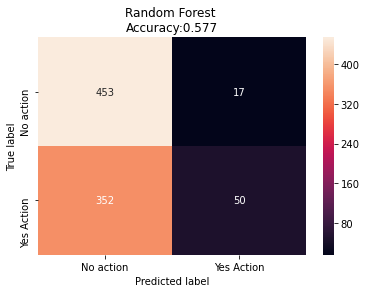

In [44]:
y_pred = rf_classifier.best_estimator_.predict(X_test)

ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))
#print('Accuracy is: ',ac)

#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


#### Feature importance

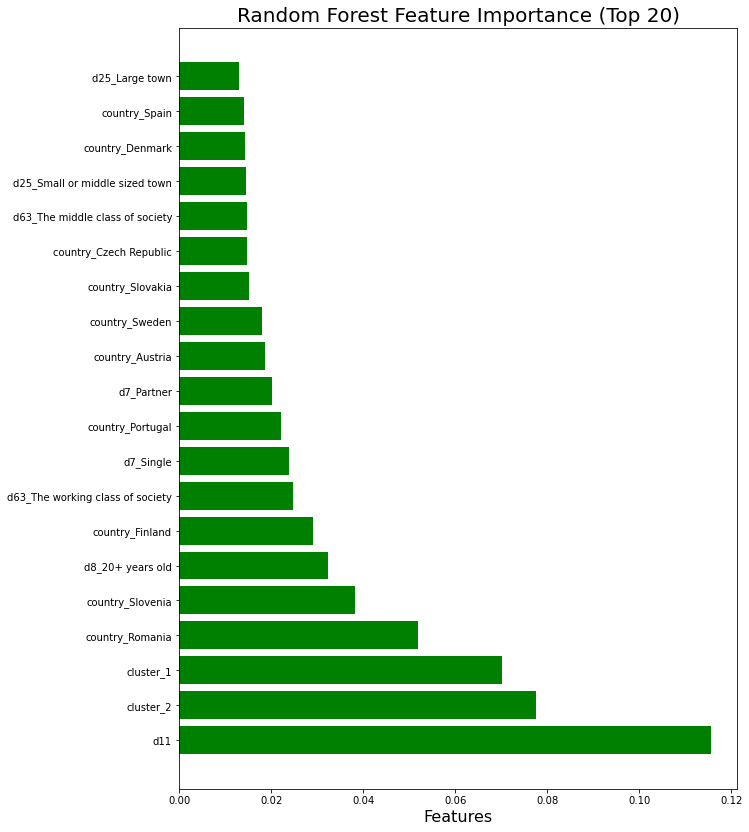

In [45]:


feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 20)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [54]:
imp = pd.read_csv('imp.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

rf = pd.DataFrame(feature_importances)
rf.rename(columns={ rf.columns[0]: "variable" }, inplace = True)

rf  = rf.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, rf, left_index=True, right_index=True)

final.rename(columns={ final.columns[4]: "importance_rf" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp.csv', index=False, encoding='utf-8')




In [14]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.64      0.56      2296
           1       0.78      0.66      0.71      4298

    accuracy                           0.65      6594
   macro avg       0.64      0.65      0.64      6594
weighted avg       0.68      0.65      0.66      6594



#### ROC 

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

roc_auc_score for Random Forest - High Risk Perception:  0.7147184676285705


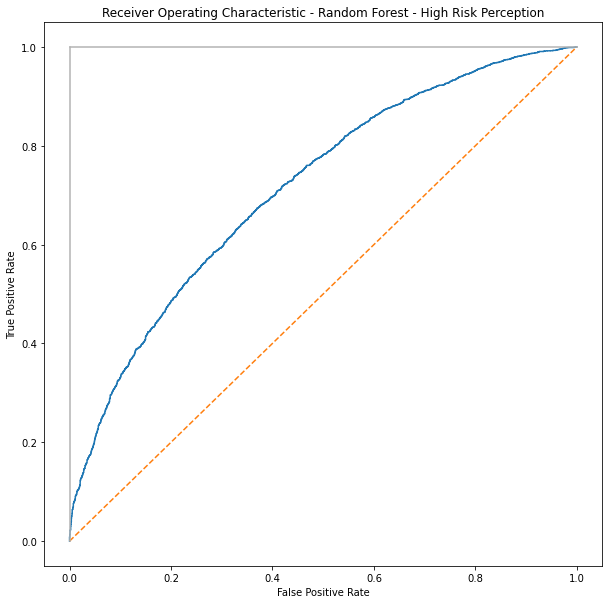

In [15]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest - High Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

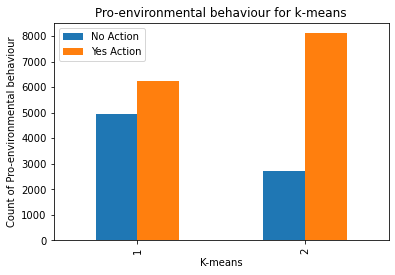

In [16]:
pd.crosstab(df['cluster'], df['qb5']).plot(kind='bar')
plt.title('Pro-environmental behaviour for k-means')
plt.xlabel('K-means')
plt.ylabel('Count of Pro-environmental behaviour')
plt.legend(["No Action", "Yes Action"]);
plt.savefig('qb5xk_means')


### High Risk Perception

In this part there is data of individuals who have a high Climate Change Risk Perception (q2 >= 6).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [17]:
cc_num = df1[['qb5', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]
cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']
seed = 123  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)


In [18]:
c = y_test.groupby('qb5')['qb5'].count()
c #unbalanced

qb5
0    1825
1    3897
Name: qb5, dtype: int64

In [19]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.56726931, 0.73424266])

In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight= {0: 1.56739773 , 1:0.73421448})
# Random search of parameters, using 3 fold cross validation, 
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1,random_state = seed)


# Fit the random search model
rf_classifier.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 1.56739773,
                                                                  1: 0.73421448}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                           

In [21]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)


{'n_estimators': 516, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_leaf_nodes': 39, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
RandomForestClassifier(class_weight={0: 1.56739773, 1: 0.73421448},
                       max_depth=100, max_leaf_nodes=39, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=516)


Accuracy is:  0.6515204473960153


Text(0.5, 15.0, 'Predicted label')

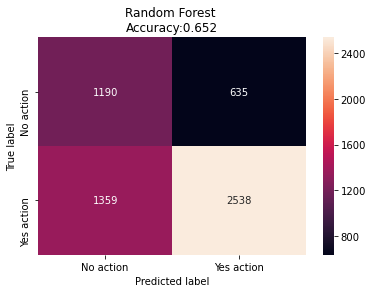

In [22]:
y_pred = rf_classifier.best_estimator_.predict(X_test)

ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))
print('Accuracy is: ',ac)

#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes action'], 
                     columns = ['No action','Yes action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


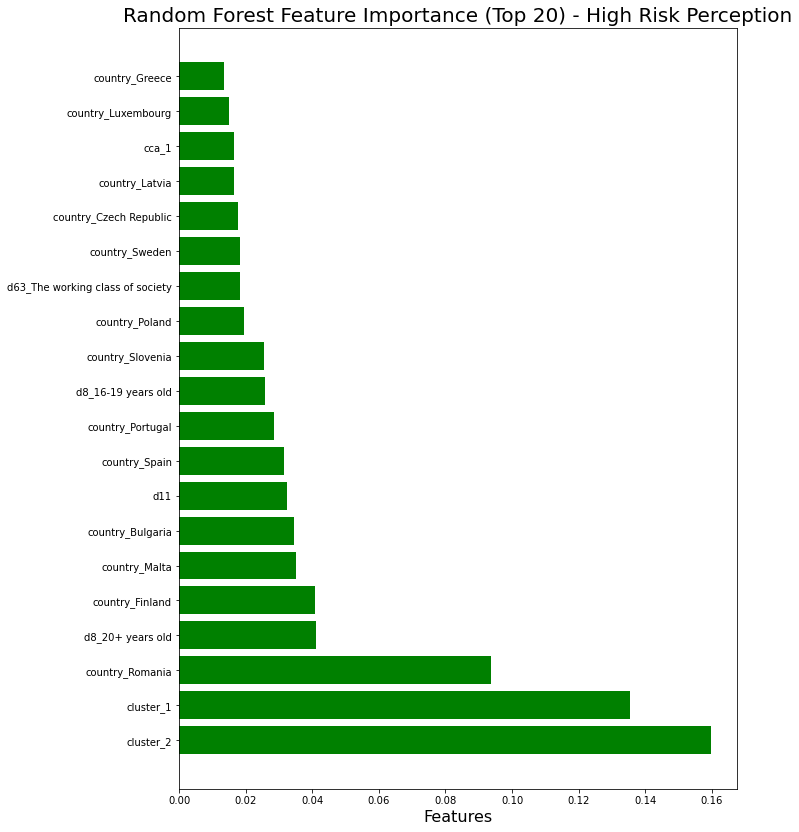

In [23]:

feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 20) - High Risk Perception',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


In [24]:
feature_importances

[('d11', 0.0323720103208541),
 ('d1_Centre', 0.0023091467727551977),
 ('d1_Centre-letf', 0.010809210052439063),
 ('d1_Centre-right', 0.010576838193181495),
 ('d1_Left', 0.0030399927111867332),
 ('d1_Not positionable', 0.003308198596394997),
 ('d1_Right', 0.0031812069683012875),
 ('d10_Man', 0.007492287398217037),
 ('d10_Woman', 0.0063899043095144185),
 ('country_Austria', 0.010085359870700314),
 ('country_Belgium', 0.00251487391871373),
 ('country_Bulgaria', 0.03445245828547969),
 ('country_Croatia', 0.005022137903496922),
 ('country_Cyprus', 0.0020545257970771896),
 ('country_Czech Republic', 0.017769035006251394),
 ('country_Denmark', 0.002567322772802148),
 ('country_Estonia', 0.004237891026266189),
 ('country_Finland', 0.04068301179429035),
 ('country_France', 0.0025949700520690134),
 ('country_Germany', 0.008799214286634391),
 ('country_Greece', 0.013551493456319903),
 ('country_Hungary', 0.003417665132253317),
 ('country_Ireland', 0.001911237143730136),
 ('country_Italy', 0.00926

In [25]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.65      0.54      1825
           1       0.80      0.65      0.72      3897

    accuracy                           0.65      5722
   macro avg       0.63      0.65      0.63      5722
weighted avg       0.69      0.65      0.66      5722



roc_auc_score for Random Forest - High Risk Perception:  0.7161371058172602


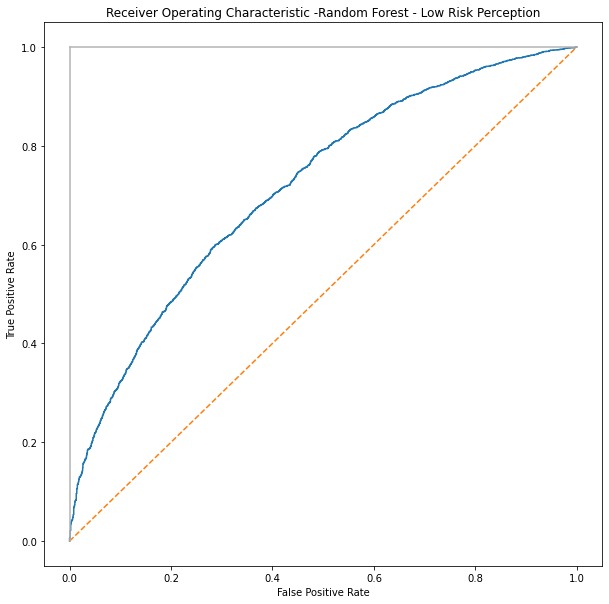

In [26]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Random Forest - Low Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Low Risk Perception


In this part there is data of individuals who have a low Climate Change Risk Perception (q2 <= 5).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes


In [27]:

cc_num = df2[['qb5', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']
seed = 123  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)


In [28]:
c = y_test.groupby('qb5')['qb5'].count()
c #balanced

qb5
0    470
1    402
Name: qb5, dtype: int64

In [29]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))


print(class_weights)

[0.92707384 1.08537887]


In [30]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight= {0:0.9272727 , 1:1.08510638})

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1,random_state = seed)


# Fit the random search model
rf_classifier.fit(X_train, y_train.values.ravel())



RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 0.9272727,
                                                                  1: 1.08510638}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                            

In [31]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)

{'n_estimators': 161, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 37, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': True}
RandomForestClassifier(class_weight={0: 0.9272727, 1: 1.08510638}, max_depth=70,
                       max_features='log2', max_leaf_nodes=37,
                       min_samples_split=5, n_estimators=161)


Accuracy is:  0.6548165137614679


Text(0.5, 15.0, 'Predicted label')

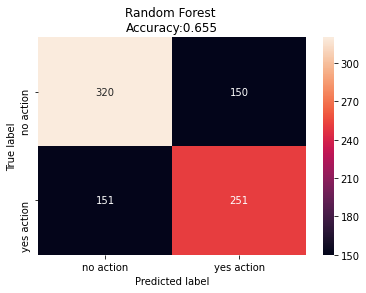

In [32]:

y_pred = rf_classifier.best_estimator_.predict(X_test)


ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))
print('Accuracy is: ',ac)



#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['no action','yes action '], 
                     columns =  ['no action','yes action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


In [33]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       470
           1       0.63      0.62      0.63       402

    accuracy                           0.65       872
   macro avg       0.65      0.65      0.65       872
weighted avg       0.65      0.65      0.65       872



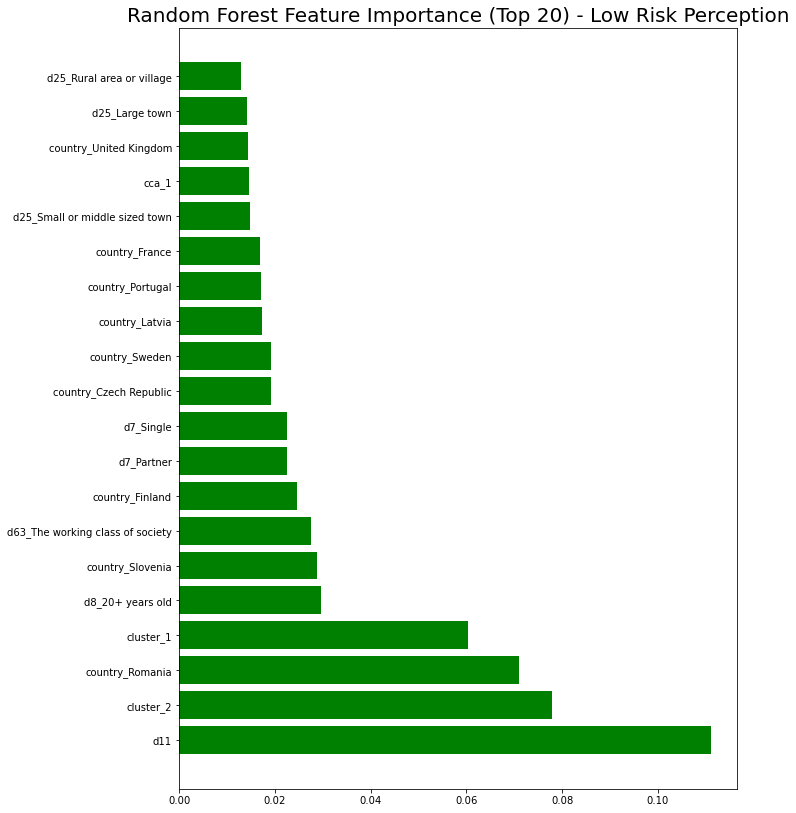

In [34]:
feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 20) - Low Risk Perception',
          fontdict= {'fontsize' : 20})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


In [35]:
feature_importances

[('d11', 0.11099988906806005),
 ('d1_Centre', 0.010747338657962992),
 ('d1_Centre-letf', 0.011147534707613708),
 ('d1_Centre-right', 0.010125960379459476),
 ('d1_Left', 0.011103240651724671),
 ('d1_Not positionable', 0.01057951162103671),
 ('d1_Right', 0.008072012573113295),
 ('d10_Man', 0.012260528856396476),
 ('d10_Woman', 0.010539677199689032),
 ('country_Austria', 0.01131688164367211),
 ('country_Belgium', 0.006100977737556528),
 ('country_Bulgaria', 0.005214889809802934),
 ('country_Croatia', 0.008089682164384373),
 ('country_Cyprus', 0.00644902400484285),
 ('country_Czech Republic', 0.019237559850751755),
 ('country_Denmark', 0.010958339209332662),
 ('country_Estonia', 0.008087629506914861),
 ('country_Finland', 0.024607773904278787),
 ('country_France', 0.016925561394097607),
 ('country_Germany', 0.008705084948279483),
 ('country_Greece', 0.007913435666482563),
 ('country_Hungary', 0.00621519585675097),
 ('country_Ireland', 0.007137330654780472),
 ('country_Italy', 0.01179207563

roc_auc_score for Random Forest - Low Risk Perception:  0.7017995130729332


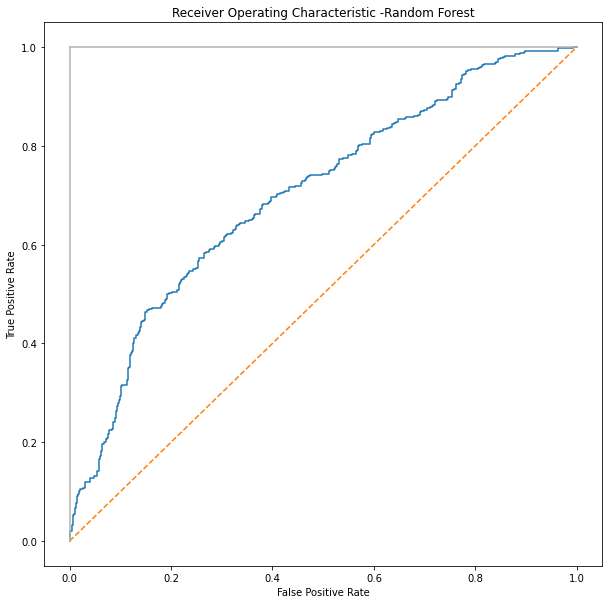

In [36]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - Low Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Random Forest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REFERENCES 

https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

